# Radon - HMC edition


In [ ]:
%pip install --upgrade pip
%pip install -q git+https://github.com/blackjax-devs/blackjax.git@7100bca3ea39def4bbeaa179a015f67abfa0b1f0
%pip install --upgrade -q git+https://github.com/kuperov/welford.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done


In [ ]:
%pip freeze

absl-py==1.4.0
alabaster==0.7.13
albumentations==1.2.1
altair==4.2.2
anyio==3.6.2
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arviz==0.15.1
astropy==5.2.2
astunparse==1.6.3
attrs==22.2.0
audioread==3.0.0
autograd==1.5
Babel==2.12.1
backcall==0.2.0
beautifulsoup4==4.11.2
blackjax @ git+https://github.com/blackjax-devs/blackjax.git@7100bca3ea39def4bbeaa179a015f67abfa0b1f0
bleach==6.0.0
blis==0.7.9
blosc2==2.0.0
bokeh==2.4.3
branca==0.6.0
CacheControl==0.12.11
cached-property==1.5.2
cachetools==5.3.0
catalogue==2.0.8
certifi==2022.12.7
cffi==1.15.1
chardet==4.0.0
charset-normalizer==2.0.12
chex==0.1.7
click==8.1.3
cloudpickle==2.2.1
cmake==3.25.2
cmdstanpy==1.1.0
colorcet==3.0.1
colorlover==0.3.0
community==1.0.0b1
confection==0.0.4
cons==0.4.5
contextlib2==0.6.0.post1
contourpy==1.0.7
convertdate==2.4.0
cryptography==40.0.1
cufflinks==0.17.3
cupy-cuda11x==11.0.0
cvxopt==1.3.0
cvxpy==1.3.1
cycler==0.11.0
cymem==2.0.7
Cython==0.29.34
dask==2022.12.1
datascience==0.17.6


In [ ]:
from jax.config import config
config.update("jax_enable_x64", True)
for dev in jax.devices():
  print(dev)

In [ ]:
import blackjax as bj
assert bj.__version__ == "0.9.7.dev153+g7100bca"

In [ ]:
# ! rm radon_mod.json.zip
! [ -f radon_mod.json.zip ] || wget -q -O radon_mod.json.zip 'https://github.com/stan-dev/posteriordb/blob/master/posterior_database/data/data/radon_mod.json.zip?raw=true'
zdat = '/content/radon_mod.json.zip'

In [ ]:
import json  
import zipfile  
import os
import jax
import jax.numpy as jnp
from jax.scipy.special import logsumexp
from tensorflow_probability.substrates import jax as tfp
from typing import NamedTuple, Dict, Callable, Tuple
from welford import *
import chex
import optax
import matplotlib.pyplot as plt
tfd = tfp.distributions
tfb = tfp.bijectors

In [ ]:
from typing import NamedTuple, Callable

class Model(NamedTuple):
    """Container for cross-validatable model functions."""
    num_folds: int
    num_models: int
    logjoint_density: Callable
    log_pred: Callable
    make_initial_pos: Callable
    to_constrained: Callable


Load data, wrap into a dict so we can easily swap out with simulated data if needed

In [ ]:
# Load radon data from zip file.
data = {}
with zipfile.ZipFile(zdat, "r") as z:
    for filename in z.namelist():
        with z.open(filename) as f:
            data = json.loads(f.read().decode('utf-8'))
data = {k: jnp.array(v) for (k, v) in data.items()}

sigma_a_tfm = tfb.Exp()
sigma_y_tfm = tfb.Exp()

J, N = data['J'], data['N']
#county_idx = data['county_idx'] - 1
county_idx = data['county'] - 1
# y, log_uppm, floor_measure = data['log_radon'], data['log_uppm'], data['floor_measure']
y, log_uppm, floor_measure = data['y'], data['u'], data['x']

orig_data = {
    'y': y,
    'log_uppm': log_uppm,
    'floor_measure': floor_measure,
    'J': J,
    'N': N
}

In [ ]:
# Posterior DB model
# https://github.com/stan-dev/posteriordb/blob/master/posterior_database/models/stan/radon_hierarchical_intercept_noncentered.stan

class Theta(NamedTuple):
    alpha_raw: jax.Array  # vector[J] a;
    beta: jax.Array  # vector[2] beta;
    mu_alpha: jax.Array  # real mu_a;
    sigma_alpha: jax.Array  # real<lower=0> sigma_alpha;
    sigma_y: jax.Array  # real<lower=0> sigma_y;

def make_initial_pos(key: jax.random.KeyArray) -> Theta:
    k1, k2, k3, k4, k5 = jax.random.split(key, 5)
    theta = Theta(
        alpha_raw=jax.random.normal(key=k1, shape=(J,)),
        beta=jax.random.normal(key=k2, shape=(2,)),
        mu_alpha=jax.random.normal(key=k3),
        sigma_alpha=jax.random.normal(key=k4),
        sigma_y=jax.random.normal(key=k5),
    )
    return theta

def to_constrained(theta: Theta) -> Theta:
    return Theta(
        alpha_raw=theta.alpha_raw,
        beta=theta.beta,
        mu_alpha=theta.mu_alpha,
        sigma_alpha=sigma_a_tfm.forward(theta.sigma_alpha),
        sigma_y=sigma_y_tfm.forward(theta.sigma_y),
    )


In [ ]:
def make_densities(data):
  
  def logjoint_density(theta: Theta, fold_id: int, model_id: int, prior_only: bool = False) -> jax.Array:
      """Log joint density for a given fold.
      
      Args:
          theta: model parameters
          fold_id: zero-based fold id for training set
          model_id: 0 for model A, 1 for model B
          prior_only: if True, only return prior density
      
      Returns:
          log density
      """
      # transform to constrained space
      sigma_alpha = sigma_a_tfm.forward(theta.sigma_alpha)
      sigma_y = sigma_y_tfm.forward(theta.sigma_y)
      sigma_alpha_ldj = sigma_a_tfm.forward_log_det_jacobian(theta.sigma_alpha)
      sigma_y_ldj = sigma_y_tfm.forward_log_det_jacobian(theta.sigma_y)
      ldj = sigma_y_ldj + sigma_alpha_ldj
      # prior is same for all folds
      lp = (
          tfd.Normal(loc=0, scale=1).log_prob(sigma_alpha)
          + tfd.Normal(loc=0, scale=1).log_prob(sigma_y)
          + tfd.Normal(loc=0, scale=10.).log_prob(theta.mu_alpha)
          + tfd.Normal(loc=0, scale=10.).log_prob(theta.beta).sum()
          + tfd.Normal(loc=0, scale=1.).log_prob(theta.alpha_raw).sum()
      )
      # noncentering transform: alpha ~ normal(mu_alpha, sigma_alpha)
      alpha = theta.mu_alpha + sigma_alpha * theta.alpha_raw
      # likelihood for fold
      include_log_uppm = 1.0 * (model_id == 0)  # only include log_uppm in model A
      muj = alpha[county_idx] + log_uppm * theta.beta[0] * include_log_uppm
      mu = muj + floor_measure * theta.beta[1]
      ll_contribs = tfd.Normal(loc=mu, scale=sigma_y).log_prob(y)
      #ll_contribs = tfd.StudentT(df=3, loc=mu, scale=sigma_y).log_prob(y)
      fold_mask = (county_idx != fold_id).astype(jnp.float32)
      lhood_mask = 1.0 * (not prior_only)
      ll = (fold_mask * ll_contribs).sum() * lhood_mask
      return lp + ll + ldj

  def log_pred(theta: Theta, fold_id: int, model_id: int) -> jax.Array:
      """Log predictive density for a given fold.
      
      Args:
      theta: model parameters
      fold_id: zero-based fold id for test set
      """
      sigma_alpha = sigma_a_tfm.forward(theta.sigma_alpha)
      sigma_y = sigma_y_tfm.forward(theta.sigma_y)
      # noncentering transform: alpha ~ normal(mu_alpha, sigma_alpha)
      alpha = theta.mu_alpha + sigma_alpha * theta.alpha_raw
      # pred density for fold -- only include log_uppm in model 0
      muj = alpha[county_idx] + log_uppm * jnp.where(model_id == 0, theta.beta[0], 0.)
      mu = muj + floor_measure * theta.beta[1]
      ll_contribs = tfd.Normal(loc=mu, scale=sigma_y).log_prob(y)
      #ll_contribs = tfd.StudentT(df=3, loc=mu, scale=sigma_y).log_prob(y)
      lpred = jnp.where(jnp.bitwise_or(county_idx == fold_id, fold_id == -1), ll_contribs, 0.)
      return jnp.sum(lpred)

  return logjoint_density, log_pred

In [ ]:
num_folds=J
num_models=2
num_chains=16
batch_size=150
num_integration_steps=10

In [ ]:
def prior_draw(rng_key):
    keys = jax.random.split(rng_key, 6)
    sigma_alpha = jax.random.normal(key=keys[0])
    sigma_y = jax.random.normal(key=keys[1])
    mu_alpha = 10.*jax.random.normal(key=keys[2])
    beta = 10.*jax.random.normal(key=keys[3], shape=(2,))
    alpha = mu_alpha + sigma_alpha * jax.random.normal(key=keys[4], shape=(J,))
    muj = alpha[county_idx] + log_uppm * beta[0]
    mu = muj + floor_measure * beta[1]
    y = mu + sigma_y*jax.random.normal(key=keys[5], shape=(N,))
    return dict(
        sigma_alpha=sigma_alpha,
        sigma_y=sigma_y,
        mu_alpha=mu_alpha,
        beta=beta,
        alpha=alpha,
        y=y)

In [ ]:
prior_data = prior_draw(rng_key=jax.random.PRNGKey(-1))
# logjoint_density, log_pred = make_densities(orig_data)
logjoint_density, log_pred = make_densities(prior_data)

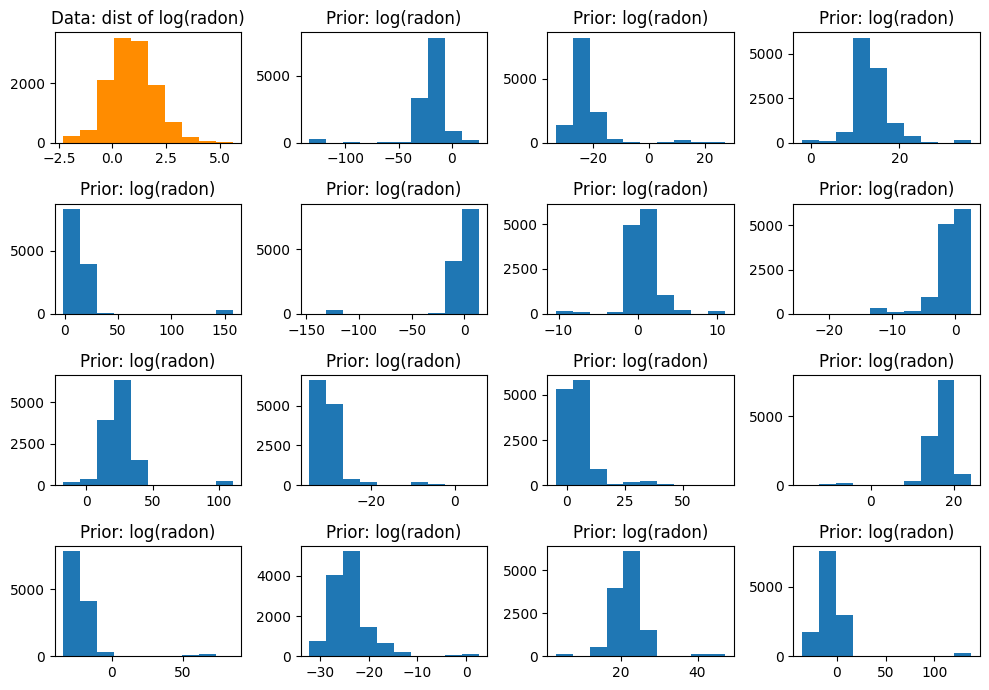

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 7))

p_data = axes[0][0]
p_data.hist(y, color='darkorange')
p_data.set_title('Data: dist of log(radon)')

# draw from prior
for i in range(1,4*4):
    pd = prior_draw(rng_key=jax.random.PRNGKey(i))

    p_prior = axes[i//4][i%4]
    p_prior.hist(pd['y'])
    p_prior.set_title('Prior: log(radon)')

fig.tight_layout()

In [ ]:
def find_initial_params(rng_key, fold_id, model_id):
    params = make_initial_pos(rng_key)
    optimizer = optax.adam(learning_rate=0.1)
    f = lambda x: -logjoint_density(x, fold_id, model_id, prior_only=False)
    state = optimizer.init(params)
    def loop_body(i, carry):
        params, state = carry
        _, grads = jax.value_and_grad(f)(params)
        updates, new_state = optimizer.update(grads, state)
        new_params = optax.apply_updates(params, updates)
        return new_params, new_state
    params, state = jax.lax.fori_loop(0, 100, loop_body, (params, state))
    return params


Window adaptation to find a good step size, inverse mass matrix

In [ ]:
full_data_ldens = lambda x: logjoint_density(x, -1, 0, prior_only=False)
adapt = bj.window_adaptation(bj.hmc, full_data_ldens, num_integration_steps=num_integration_steps, progress_bar=True)
adapt_res, _ = adapt.run(jax.random.PRNGKey(123), find_initial_params(jax.random.PRNGKey(0), -1, 0), num_steps=5000)
print(f"Step size = {adapt_res.parameters['step_size']:.4f}")

Running window adaptation



Step size = 0.1203


In [ ]:
class ExtendedState(NamedTuple):
    """MCMC state--extends regular GHMC state variable--also includes batch welford accumulators"""
    state: jax.Array  # current HMC state
    rng_key: jax.random.KeyArray  # current random seed
    pred_ws: LogWelfordState  # accumulator for log predictive
    pred_bws: BatchLogWelfordState  # batch accumulator for log predictive, size b
    pred_bws3: BatchLogWelfordState  # batch accumulator for log predictive, size floor(b/3)
    divergences: jax.Array  # divergence counts (int array)

def init_ext_state(state, rng_key):
    """Create initial state"""
    return ExtendedState(
        state=state,
        rng_key=rng_key,
        pred_ws=log_welford_init(()),
        pred_bws=batch_log_welford_init((), batch_size),
        pred_bws3=batch_log_welford_init((), batch_size // 3),
        divergences=jnp.array(0, dtype=jnp.int32),
    )

def reset_ext_state(state):
    """Reset averages after warmup"""
    return ExtendedState(
        state=state.state,
        rng_key=state.rng_key,
        pred_ws=log_welford_init(()),
        pred_bws=batch_log_welford_init((), batch_size),
        pred_bws3=batch_log_welford_init((), batch_size // 3),
        divergences=jnp.array(0, dtype=jnp.int32),
    )

def inference_loop(ext_states, fold_id, model_id, num_samples, is_online):
    hmc = bj.hmc(lambda x: logjoint_density(x, fold_id, model_id), **adapt_res.parameters)
    def one_chain_inference_loop(state):  # Single chain inference loop
        def one_mcmc_step(ext_state: ExtendedState, _idx):  # Single chain, single MCMC step.
            iter_key, carry_key = jax.random.split(ext_state.rng_key)
            chain_state, chain_info = hmc.step(iter_key, ext_state.state)
            elpd_contrib = log_pred(chain_state.position, fold_id, model_id)
            carry_state = ExtendedState(
                state=chain_state,
                rng_key=carry_key,
                pred_ws=log_welford_add(elpd_contrib, ext_state.pred_ws),
                pred_bws=batch_log_welford_add(elpd_contrib, ext_state.pred_bws),
                pred_bws3=batch_log_welford_add(elpd_contrib, ext_state.pred_bws3),
                divergences=ext_state.divergences + chain_info.is_divergent,
            )
            if is_online:
                return carry_state, None  # don't retain chain trace
            else:
                return carry_state, chain_state.position
        next_state, trace = jax.lax.scan(one_mcmc_step, state, jnp.arange(num_samples))
        return next_state, trace
    # run all chains for this fold in parallel
    next_state = jax.vmap(one_chain_inference_loop)(ext_states)
    return next_state


Initialize inference

In [ ]:
state_k, sampling_k = jax.random.split(jax.random.PRNGKey(0))
fm_hmc = bj.hmc(lambda x: logjoint_density(x, -1, 0), **adapt_res.parameters)
state_ks = jax.random.split(state_k, num_chains)
fm_init_pos = jax.vmap(find_initial_params, in_axes=(0, None, None))(state_ks, -1, 0)
sampling_ks = jax.random.split(sampling_k, num_chains)
fm_init_hmcstates = jax.vmap(fm_hmc.init)(fm_init_pos)
fm_init_state = jax.vmap(init_ext_state)(fm_init_hmcstates, sampling_ks)

## Batched online inference (full data)

In [ ]:
burnin_size = 1_000
state, _ = inference_loop(fm_init_state, -1, 0, burnin_size, True)
state = jax.vmap(reset_ext_state)(state)  # discard values accumulated during burn-in
means = []
for i in range(100):
    state, _ = inference_loop(state, -1, 0, batch_size, True)
    pmeans = log_welford_mean(state.pred_ws)
    means.append(pmeans)
    if jnp.any(state.divergences > 0):
        print(f"WARNING: {state.divergences.sum()} divergences")
means = jnp.stack(means)

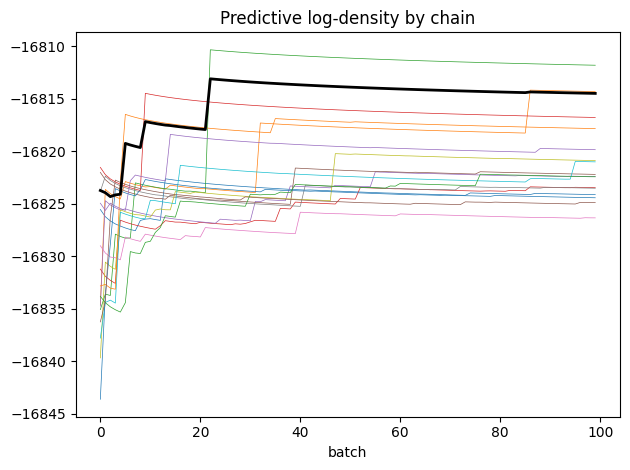

In [ ]:
import matplotlib.pyplot as plt
plt.plot(means, linewidth=0.5)
plt.plot(logsumexp(means, axis=1) - jnp.log(num_chains), linewidth=2, color='k')
plt.title('Predictive log-density by chain')
plt.xlabel('batch')
plt.tight_layout()

In [ ]:
state, trace = inference_loop(state, -1, 0, 5_000, False)
import arviz as az
constrained_trace = jax.vmap(to_constrained)(trace)
idata = az.convert_to_inference_data({
    v : constrained_trace[i] for i, v in enumerate(trace._fields)})

In [ ]:
az.summary(idata, var_names=['sigma_alpha','sigma_y','mu_alpha','beta'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma_alpha,0.553,0.025,0.506,0.600,0.000,0.000,4703.0,11093.0,1.00
sigma_y,0.925,0.006,0.914,0.936,0.000,0.000,36008.0,54954.0,1.00
mu_alpha,0.997,0.042,0.915,1.076,0.001,0.001,3534.0,8242.0,1.00
beta[0],-0.057,0.053,-0.157,0.042,0.001,0.001,3811.0,8877.0,1.01
beta[1],-0.076,0.006,-0.088,-0.064,0.000,0.000,39433.0,59374.0,1.00


In [ ]:
summ = az.summary(idata)
nonmix = summ['r_hat'] > 1.03
print(f"Non-mixing variables: {', '.join(summ.index[nonmix])}")

Non-mixing variables: 


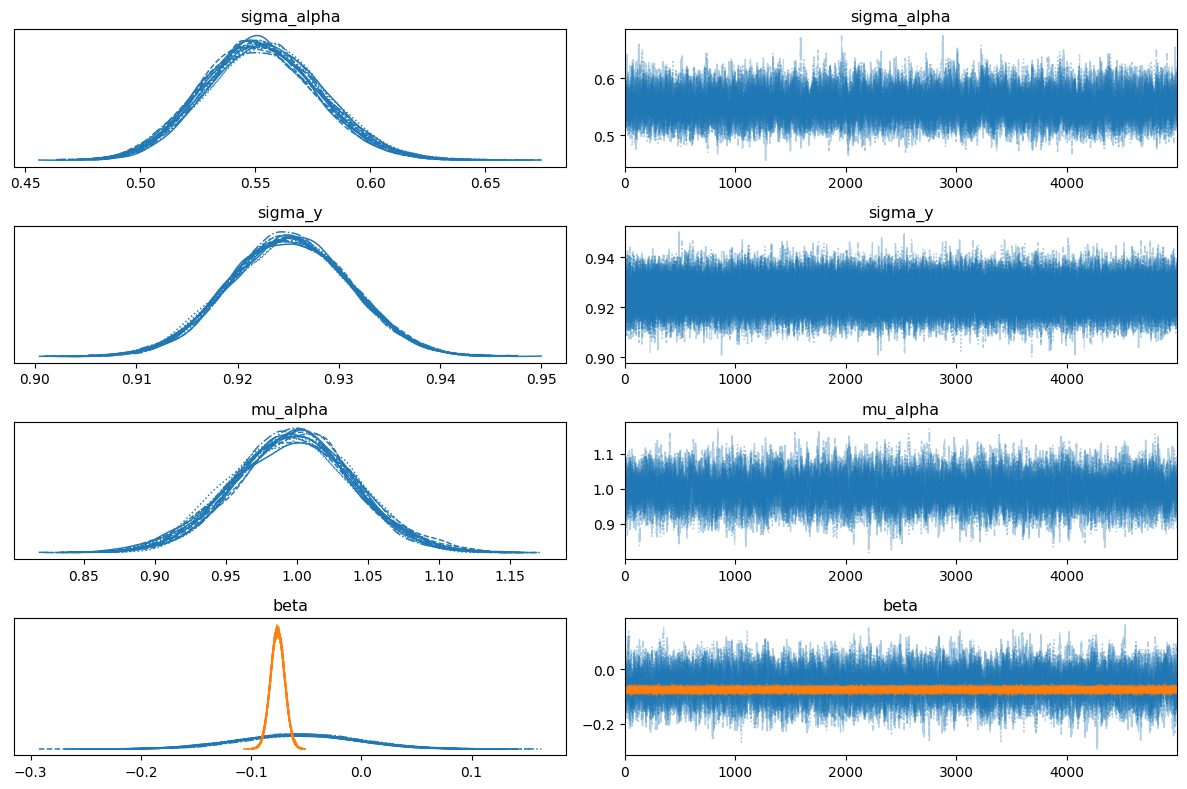

In [ ]:
az.plot_trace(idata, var_names=['sigma_alpha','sigma_y','mu_alpha','beta']);
plt.tight_layout()

## Batched online inference (one fold)


In [ ]:
burnin_size = 1_000
state, _ = inference_loop(fm_init_state, -1, 0, burnin_size, True)
state = jax.vmap(reset_ext_state)(state)  # discard values accumulated during burn-in
means = []
for i in range(100):
    state, _ = inference_loop(state, -1, 0, batch_size, True)
    pmeans = log_welford_mean(state.pred_ws)
    means.append(pmeans)
    if jnp.any(state.divergences > 0):
        print(f"WARNING: {state.divergences.sum()} divergences")
means = jnp.stack(means)

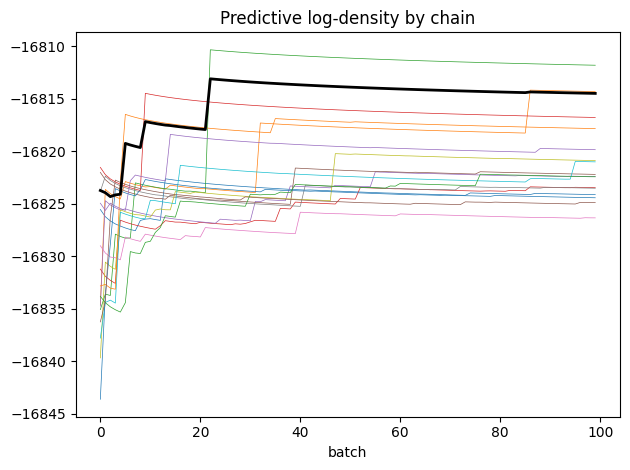

In [ ]:
import matplotlib.pyplot as plt
plt.plot(means, linewidth=0.5)
plt.plot(logsumexp(means, axis=1) - jnp.log(num_chains), linewidth=2, color='k')
plt.title('Predictive log-density by chain')
plt.xlabel('batch')
plt.tight_layout()

## Batched offline inference (one fold)


In [ ]:
burnin_size = 1_000
state, _ = inference_loop(fm_init_state, -1, 0, burnin_size, True)
state = jax.vmap(reset_ext_state)(state)  # discard values accumulated during burn-in
means = []
for i in range(100):
    state, _ = inference_loop(state, -1, 0, batch_size, True)
    pmeans = log_welford_mean(state.pred_ws)
    means.append(pmeans)
    if jnp.any(state.divergences > 0):
        print(f"WARNING: {state.divergences.sum()} divergences")
means = jnp.stack(means)

def inference_loop(ext_states, fold_id, model_id, num_samples, is_online):
    hmc = bj.hmc(lambda x: logjoint_density(x, fold_id, model_id), **adapt_res.parameters)
    def one_chain_inference_loop(state):  # Single chain inference loop
        def one_mcmc_step(ext_state: ExtendedState, _idx):  # Single chain, single MCMC step.
            iter_key, carry_key = jax.random.split(ext_state.rng_key)
            chain_state, chain_info = hmc.step(iter_key, ext_state.state)
            elpd_contrib = log_pred(chain_state.position, fold_id, model_id)
            carry_state = ExtendedState(
                state=chain_state,
                rng_key=carry_key,
                pred_ws=log_welford_add(elpd_contrib, ext_state.pred_ws),
                pred_bws=batch_log_welford_add(elpd_contrib, ext_state.pred_bws),
                pred_bws3=batch_log_welford_add(elpd_contrib, ext_state.pred_bws3),
                divergences=ext_state.divergences + chain_info.is_divergent,
            )
            if is_online:
                return carry_state, None  # don't retain chain trace
            else:
                return carry_state, chain_state.position
        next_state, trace = jax.lax.scan(one_mcmc_step, state, jnp.arange(num_samples))
        return next_state, trace
    # run all chains for this fold in parallel
    next_state = jax.vmap(one_chain_inference_loop)(ext_states)
    return next_state


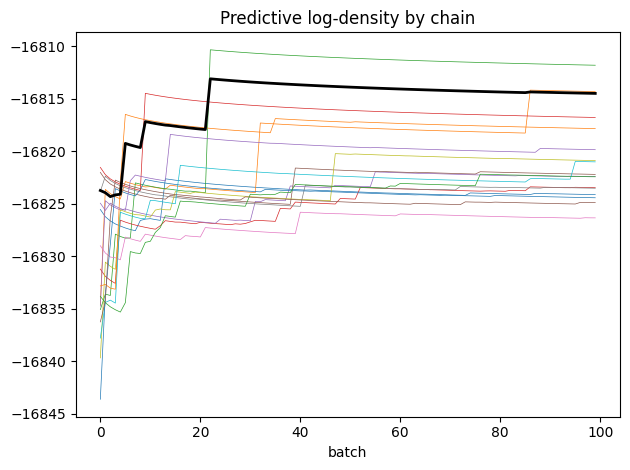

In [ ]:
import matplotlib.pyplot as plt
plt.plot(means, linewidth=0.5)
plt.plot(logsumexp(means, axis=1) - jnp.log(num_chains), linewidth=2, color='k')
plt.title('Predictive log-density by chain')
plt.xlabel('batch')
plt.tight_layout()